In [875]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 

In [876]:
import pickle
import os

In [877]:
def load_batch(filename):

    with open(filename, 'rb') as f:
        datadict = pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        X.resize(10000, 3, 32, 32)
        X = X / np.float32(256)

        Y = np.array(Y).astype(np.uint8) 
        return X, Y

In [878]:
def load_images(root):

    xs = []
    ys = []

    for batch in range(1,6):
        f = os.path.join(root, 'data_batch_%d' % (batch, ))
        X, Y = load_batch(f)
        xs.append(X)
        ys.append(Y)

    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)

    Xte, Yte = load_batch(os.path.join(root, 'test_batch'))

    return Xtr, Ytr, Xte, Yte

In [923]:
def build_cnn(input_var=None):
    network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),
                                        input_var=input_var)
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=64, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=128, filter_size=(3, 3),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=200, filter_size=(3, 3),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=700,
            nonlinearity=lasagne.nonlinearities.rectify)
    
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)
    
    return network

In [924]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [925]:
def Get_pred(inputs, batch_size):
    y_pred = []
    for batch in range(0,inputs.shape[0],batch_size):
        y_pred.append(f_predict(inputs[batch:batch + batch_size]))
    return np.concatenate(y_pred)

def Get_pred_3(inputs, batch_size):
    y_pred = []
    for batch in range(0,inputs.shape[0],batch_size):
        y_pred.append(f_predict_3(inputs[batch:batch + batch_size]))
    return np.concatenate(y_pred)

In [926]:
loc = './data'
X_train, y_train, X_test, y_test = load_images(loc)

In [927]:
val_size = 5000
val_indexes = np.random.randint(0,len(y_train),val_size)
train_indexes = list(set(range(len(y_train))) - set(val_indexes))
X_val = X_train[val_indexes]
y_val = y_train[val_indexes]
X_train = X_train[train_indexes]
y_train = y_train[train_indexes]

In [928]:
input_var = T.tensor4('inputs')
target_var = T.ivector('inputs')
prediction = T.ivector('pred')

In [929]:
network = build_cnn(input_var)

In [930]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

In [953]:
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.001, momentum=0.9)

In [954]:
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)

In [955]:
test_loss = test_loss.mean()

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                        dtype=theano.config.floatX)

In [956]:
new_pred = test_prediction.argsort(-1)
pred = test_prediction.argmax(-1)
f_predict = theano.function([input_var], pred)
f_predict_3 = theano.function([input_var], new_pred)

train_fn = theano.function([input_var, target_var], 
                           loss, 
                           updates=updates,
                           allow_input_downcast=True)

val_fn = theano.function([input_var, target_var], 
                         [test_loss, test_acc],
                         allow_input_downcast=True)

In [965]:
num_epochs = 50

BATCH_SIZE = 128

In [966]:
for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, BATCH_SIZE, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, BATCH_SIZE, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1
           
    print("Epoch: {}, train:{}, val:{}".format(epoch, 
                                               train_err/train_batches,
                                               val_err/val_batches))
y_pred = Get_pred(X_test,100)
print(classification_report(y_pred,y_test))

Epoch: 0, train:0.331138409231, val:0.654386027501
Epoch: 1, train:0.326160756201, val:0.658526527576
Epoch: 2, train:0.326550535499, val:0.659692457853
Epoch: 3, train:0.322624419549, val:0.658072199577
Epoch: 4, train:0.319696210304, val:0.660999655724
Epoch: 5, train:0.316636160185, val:0.661377036419
Epoch: 6, train:0.316918338536, val:0.662738426374
Epoch: 7, train:0.312593868577, val:0.661804217559
Epoch: 8, train:0.309478333077, val:0.659781441475
Epoch: 9, train:0.304710191514, val:0.662900704604
Epoch: 10, train:0.300432594572, val:0.668919801712
Epoch: 11, train:0.300588724887, val:0.662229647239
Epoch: 12, train:0.299170491673, val:0.659629716323
Epoch: 13, train:0.294819026848, val:0.663704098799
Epoch: 14, train:0.291525243404, val:0.66647407871
Epoch: 15, train:0.291064839187, val:0.666105278792
Epoch: 16, train:0.283702686302, val:0.671857402875
Epoch: 17, train:0.285737063493, val:0.672665308683
Epoch: 18, train:0.28205196074, val:0.675808689533
Epoch: 19, train:0.27943

In [967]:
y_true = []
y_pred = []
y_pred1 = Get_pred_3(X_test,100)
for i in range(y_test.shape[0]):
    y_true.append(int(y_test[i]))
    y_pred.append(f_predict([X_test[i]])[0])

In [969]:
def deprocess(im):
    im = np.swapaxes(np.swapaxes(im, 0, 1), 1, 2)
    im = (im - im.min())
    im = im / im.max()
    return im

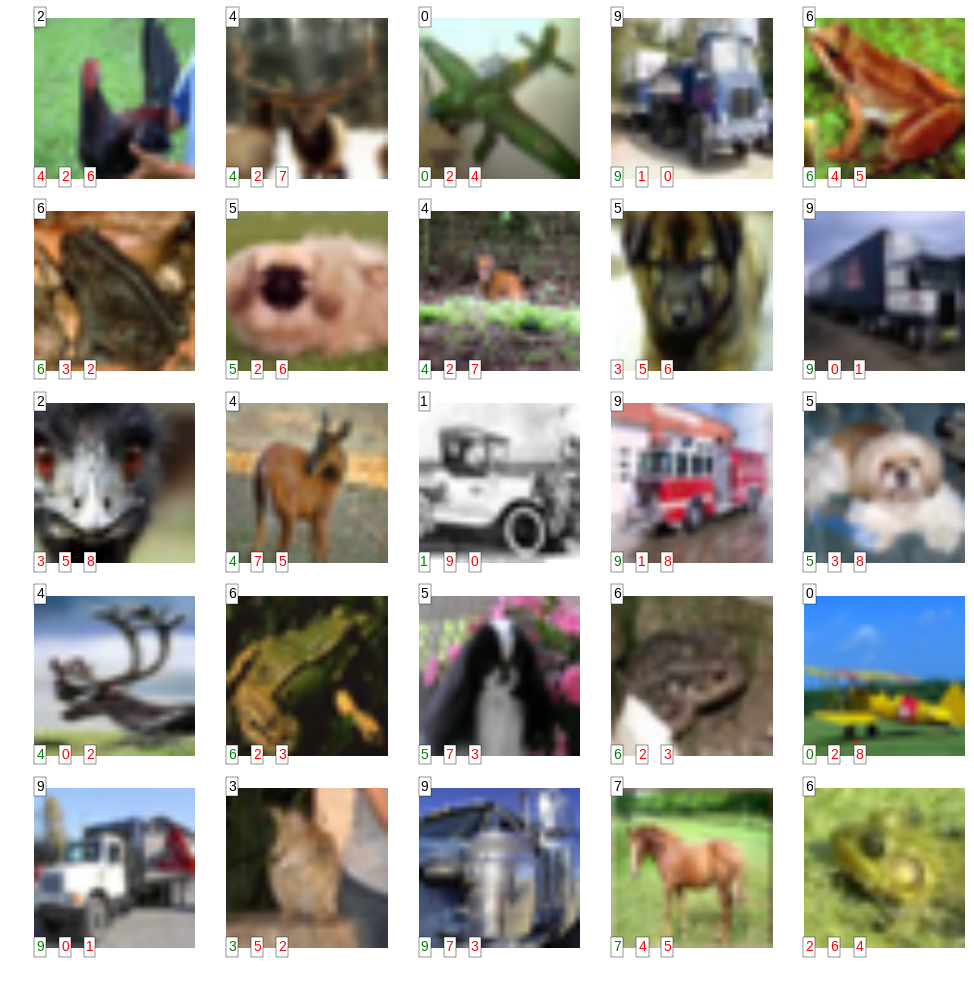

In [974]:
plt.figure(figsize=(12, 12))
j=0
for i in range(25, 50):
    plt.subplot(5, 5, j+1)
    plt.imshow(deprocess(X_test[i]))
    true = y_true[i]
    pred = y_pred1[i]
    color = 'green' if true == pred[-1] else 'red'
    plt.text(0, 0, true, color='black', bbox=dict(facecolor='white', alpha=1))
    plt.text(0, 32, pred[-1], color=color, bbox=dict(facecolor='white', alpha=1))
    plt.text(5, 32, pred[-2], color='red', bbox=dict(facecolor='white', alpha=1))
    plt.text(10, 32, pred[-3], color='red', bbox=dict(facecolor='white', alpha=1))
    j+=1

    plt.axis('off')